## Data Cleaning and Preparation

In [95]:
import os
import pandas as pd
import numpy as np
import sys
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Helper Functions (from the book)

In [96]:
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]


def skew(l, round_n=3):
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )

    return plot


def poly(x, degree=1):
    """
    Fit Polynomial
    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)

### Import and Clean Data

In [97]:
data = pd.read_csv("cs_bisnode_panel.csv")
data = data.query('year <=2015 & year >= 2012')
data = data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages'])

In [98]:
# Add all missing year and comp_id combinations -
# Originally missing combinations will have NAs in all other columns

data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [99]:
data_raw = data.copy()

### Drop the firms that went bankrupt in 2012-2013

In [100]:
data = data_raw.copy()

In [101]:
data = data.assign(
    year=lambda x: x["year"].astype(str),
    lived_at_the_end_of_the_year=lambda x: x["year"] + "-12-31",
)

In [102]:
data.comp_id.nunique()

34788

In [103]:
has_no_begin_in_2012_to_2013 = (
    data.loc[
        lambda x: (x["year"].isin(["2012","2013"]) & x["begin"].isnull()), "comp_id"
    ]
    .drop_duplicates()
    .tolist()
)

In [104]:
data = data.loc[lambda x: ~x["comp_id"].isin(has_no_begin_in_2012_to_2013)]

In [105]:
data.comp_id.nunique()

25871

In [106]:

died_in_2012 = data.loc[
    lambda x: ((x["year"] == "2012") & (x["end"] < x["lived_at_the_end_of_the_year"])),
    "comp_id",
].tolist()

died_in_2013 = data.loc[
    lambda x: ((x["year"] == "2013") & (x["end"] < x["lived_at_the_end_of_the_year"])),
    "comp_id",
].tolist()

In [107]:
data = data.loc[lambda x: ~x["comp_id"].isin(died_in_2013 + died_in_2012)]

In [108]:
# Generate status_alive = if sales larger than zero and not-NA

data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

In [109]:
data["status_alive"].value_counts()

1    78623
0    23301
Name: status_alive, dtype: int64

In [110]:
status_dead_2012 = data.loc[lambda x: (x["status_alive"] == 0) & (x["year"] == "2012"),"comp_id"].tolist()
status_dead_2013 = data.loc[lambda x: (x["status_alive"] == 0) & (x["year"] == "2013"),"comp_id"].tolist()


In [111]:
data = data.loc[lambda x: ~x["comp_id"].isin(status_dead_2013 + status_dead_2012)]

In [112]:
data.comp_id.nunique()

19738

In [113]:
data["sales"].describe()

count    7.577500e+04
mean     6.403831e+05
std      4.255746e+06
min     -9.232593e+04
25%      1.554444e+04
50%      5.005185e+04
75%      1.698963e+05
max      1.099510e+08
Name: sales, dtype: float64

In [114]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)                                                 # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),                                           # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log


<AxesSubplot: >

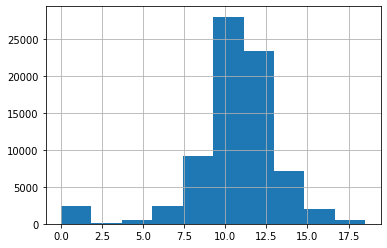

In [115]:
data.ln_sales.hist()

In [116]:
data = data.sort_values(by=["comp_id","year"])

In [117]:
data["sale_growth"] = data["ln_sales"] - data.groupby("comp_id")["ln_sales"].shift(1)

In [118]:
vars = ["comp_id","year","status_alive","sales","ln_sales","sale_growth"]

In [119]:
# Replace with 0 for new firms + add dummy to capture it

data["age"] = np.where(
    data["year"].astype(int) - data["founded_year"] < 0, 0, data["year"].astype(int) - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["sale_growth"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["sale_growth"])
)
data["new"] = np.where(data["sale_growth"].isna(), 1, data["new"])
data["sale_growth"] = np.where(data["sale_growth"].isna(), 0, data["sale_growth"])

In [120]:
data['sale_growth'].describe()

count    78952.000000
mean        -0.139853
std          1.370750
min        -13.953993
25%         -0.041475
50%          0.000000
75%          0.111136
max         14.297026
Name: sale_growth, dtype: float64

In [121]:
data['new'].describe()

count    78952.000000
mean         0.347528
std          0.476188
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: new, dtype: float64

In [122]:
data.to_csv("fin-data_train_live_raw.csv",index=False)

### Target variable

In [123]:
data = pd.read_csv("fin-data_train_live_raw.csv")

<AxesSubplot: >

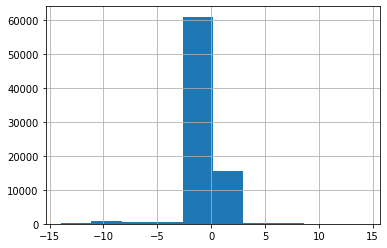

In [124]:
data.sale_growth.hist()

<AxesSubplot: >

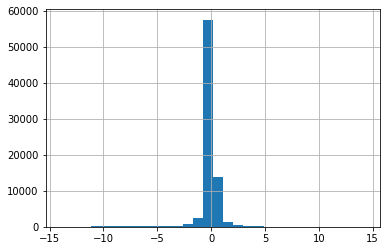

In [125]:
data.sale_growth.hist(bins=30)

Sale growth for the next year will be the target.

In [126]:
data["sale_growth_target"] = data["sale_growth"].shift(-1)

In [127]:
data[vars + ["sale_growth_target"]]

,comp_id,year,status_alive,sales,ln_sales,sale_growth,sale_growth_target
0,1.001541e+06,2012,1,1.203704e+03,7.093159,0.000000,1.529395
1,1.001541e+06,2013,1,5.555556e+03,8.622554,1.529395,-0.127833
2,1.001541e+06,2014,1,4.888889e+03,8.494720,-0.127833,0.000000
3,1.001541e+06,2015,1,4.888889e+03,8.494720,0.000000,0.000000
4,1.002029e+06,2012,1,1.136515e+06,13.943477,0.000000,-1.155013
...,...,...,...,...,...,...,...
78947,4.640446e+11,2015,1,1.051895e+07,16.168689,0.142168,0.000000
78948,4.641050e+11,2012,1,1.548778e+05,11.950392,0.000000,0.019419
78949,4.641050e+11,2013,1,1.579148e+05,11.969811,0.019419,0.079521
78950,4.641050e+11,2014,1,1.709852e+05,12.049332,0.079521,0.157481


### Feature engineering

In [128]:
# Change some industry category codes

data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [129]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

### Financial variables and ratios

In [130]:
# Assets can't be negative. Change them to 0 and add a flag.

data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    75743
1.0       45
Name: comp_id, dtype: int64

In [131]:
data['intang_assets'] = np.where(data['intang_assets'] < 0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets'] < 0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])

In [132]:
# generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

count    7.578800e+04
mean     6.163027e+05
std      1.070282e+07
min      0.000000e+00
25%      8.637037e+03
50%      3.227778e+04
75%      1.312028e+05
max      2.706026e+09
Name: total_assets_bs, dtype: float64

In [133]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [134]:
# Divide all pl_names elements by sales and create new column for it
data[[col +'_pl' for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

In [135]:
# Divide all bs_names elements by total_assets_bs and create new column for it

data[[col +'_bs' for col in bs_names]] =  data[bs_names].div(data['total_assets_bs'], axis='index').replace((np.inf, -np.inf, np.nan), (0, 0, 0))

In [136]:
# Get Nan values where total_assets_bs is NaN

for col in bs_names:
    data[col + '_bs'] = np.where(
        data['total_assets_bs'].isna(),
        np.full(len(data), np.nan),
        data[col + '_bs']
    )

### Create flags and winsorize tails

In [137]:
# Variables that represent accounting items that cannot be negative (e.g. materials)

zero = ['extra_exp_pl', 'extra_inc_pl', 'inventories_pl', 'material_exp_pl', 'personnel_exp_pl',
           'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'subscribed_cap_bs',
           'intang_assets_bs']

data[[col +'_flag_high' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))
data[[col +'_flag_error' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

In [138]:
# For vars that could be any, but are mostly between -1 and 1

anyof = ['extra_profit_loss_pl', 'inc_bef_tax_pl', 'profit_loss_year_pl', 'share_eq_bs']

data[[col +'_flag_low' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))
data[[col +'_flag_high' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))
data[[col +'_flag_zero' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
data[[col +'_quad' for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

In [139]:
# Dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

### Imputation and creation of additional firm characteristics

In [140]:
# CEO age
data['ceo_age'] = data['year'].astype(int) - data['birth_year']
data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 25).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 75).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int))


data['ceo_age'] = np.where(data['ceo_age'] < 25, 25, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'] > 75, 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

In [141]:
# Number of employees, very noisy measure
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg'])
data['flag_miss_labor_avg'] = (data['labor_avg'].isna()).astype(int)

In [142]:
data['labor_avg'].describe()

count    59746.000000
mean         1.097478
std          4.801314
min          0.000000
25%          0.118056
50%          0.250000
75%          0.631944
max        190.930557
Name: labor_avg, dtype: float64

In [143]:
data['labor_avg_mod'].describe()

count    78952.000000
mean         1.097478
std          4.176689
min          0.000000
25%          0.166667
50%          0.439394
75%          1.097478
max        190.930557
Name: labor_avg_mod, dtype: float64

In [144]:
data = data.drop(['labor_avg'], axis=1)

In [145]:
# Create category type variables
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")

In [146]:
# Create sales squared (sales in 2012 is a feature)

data['sales_mil_log_sq'] = data['sales_mil_log']**2

<AxesSubplot: >

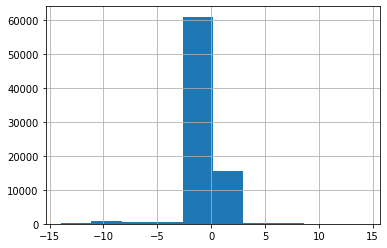

In [147]:
data.sale_growth_target.hist()

In [148]:
# No more imputation, drop obs if key vars missing
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind'])

In [149]:
# Drop missing
data = data.dropna(subset = ['age', 'foreign', 'material_exp_pl', 'm_region_loc'])
data['age'].describe()

count    68289.000000
mean        10.583520
std          7.128437
min          0.000000
25%          4.000000
50%         10.000000
75%         17.000000
max         63.000000
Name: age, dtype: float64

In [150]:
# Drop unused factor levels
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

### Create additional financial variables

In [151]:
data.comp_id.nunique()

18794

Return on Equity (ROE) = income before tax/shareholder equity

In [152]:
minimum_roe = data.loc[
    lambda x: (x["inc_bef_tax"] > 0) & (x["share_eq"] > 0) | (x["share_eq"] != 0)
].assign(ROE=lambda x: x["inc_bef_tax"] / x["share_eq"])["ROE"].min()

In [153]:
minimum_roe

-944.39999188385

Imputation rule:

- nom < 0 & denom < 0 --> minimum
- denom == 0 --> minimum

In [154]:
data = data.assign(ROE=lambda x: x["inc_bef_tax"] / x["share_eq"])

data["ROE"] = np.where((data["inc_bef_tax"] < 0) & (data["share_eq"] < 0), minimum_roe, data["ROE"])
data["ROE"] = np.where(data["share_eq"] == 0, minimum_roe, data["ROE"])

<AxesSubplot: >

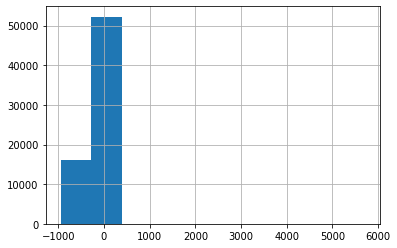

In [155]:
data["ROE"].hist()

In [156]:
data["ROE_target"] = data["ROE"].shift(-1)

EBITDA = (income before tax + amortization)/total assets

In [157]:
data.total_assets_bs.isnull().sum()

0

In [158]:
(data.total_assets_bs == 0).sum()

150

In [159]:
data["EBITDA"] = (data["inc_bef_tax"] + data["amort"]) / data["total_assets_bs"]

Imputation rule:

- denom == 0 & nom > 0 --> max
- denom == 0 & nom == 0 --> median
- denom == 0 & nom < 0 --> min

In [160]:
data["EBITDA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) > 0),
    data.loc[lambda x: x["EBITDA"] != np.inf, "EBITDA"].max(),
    data["EBITDA"],
)

data["EBITDA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) == 0),
    data.loc[lambda x: x["EBITDA"] != np.inf, "EBITDA"].median(),
    data["EBITDA"],
)

data["EBITDA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) < 0),
    data.loc[lambda x: x["EBITDA"] != -np.inf, "EBITDA"].min(),
    data["EBITDA"],
)

Return on Assets (ROA) = income before tax/total assets

In [161]:
data["ROA"] = (data["inc_bef_tax"]) / data["total_assets_bs"]

In [162]:
data["ROA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) > 0),
    data.loc[lambda x: x["ROA"] != np.inf, "ROA"].max(),
    data["ROA"],
)

data["ROA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) == 0),
    data.loc[lambda x: x["ROA"] != np.inf, "ROA"].median(),
    data["ROA"],
)

data["ROA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) < 0),
    data.loc[lambda x: x["ROA"] != -np.inf, "ROA"].min(),
    data["ROA"],
)

Sales over total assets = sales/total assets

In [163]:
data["sales_per_tot_assets"] = data["sales"] /data["total_assets_bs"]

Imputation rule:

- denom == 0 & nom > 0 --> max
- denom == 0 & nom == 0 --> median

In [164]:
data["sales_per_tot_assets"] = np.where(
    (data["total_assets_bs"] == 0) & (data["sales"] == 0),
    data.loc[lambda x: x["sales_per_tot_assets"] != np.inf, "sales_per_tot_assets"].median(),
    data["sales_per_tot_assets"],
)

data["sales_per_tot_assets"] = np.where(
    (data["total_assets_bs"] == 0) &  (data["sales"] > 0),
    data.loc[lambda x: x["sales_per_tot_assets"] != np.inf, "sales_per_tot_assets"].max(),
    data["sales_per_tot_assets"],
)

Liquidity rate = current assets/current liabilities

In [165]:
data["liquidity_rate"] = data["curr_assets"] / data["curr_liab"]

In [166]:
#Impute max if the denominator == 0 

data["liquidity_rate"] = np.where(
    data["curr_liab"] == 0,
    data["liquidity_rate"].loc[lambda x: x != np.inf].max(),
    data["liquidity_rate"],
)

Own equity rate = shareholder equity/total assets

In [167]:
data["own_equity_rate"] = data["share_eq"] / data["total_assets_bs"]

In [168]:
#Impute min if the denominator == 0 

data["own_equity_rate"] = np.where(
    data["total_assets_bs"] == 0,
    data["own_equity_rate"].loc[lambda x: x != -np.inf].min(),
    data["own_equity_rate"],
)

Now we can create the list of additional financial variables

In [169]:
financial_extras = [
    "ROE",
    "ROA",
    "sales_per_tot_assets",
    "liquidity_rate",
    "own_equity_rate",
]

In [170]:
data[financial_extras].isnull().sum()

ROE                     0
ROA                     0
sales_per_tot_assets    0
liquidity_rate          0
own_equity_rate         0
dtype: int64

In [171]:
(data[financial_extras]== np.inf).sum()

ROE                     0
ROA                     0
sales_per_tot_assets    0
liquidity_rate          0
own_equity_rate         0
dtype: int64

In [172]:
(data[financial_extras]== -np.inf).sum()

ROE                     0
ROA                     0
sales_per_tot_assets    0
liquidity_rate          0
own_equity_rate         0
dtype: int64

### Determine the sample

We will take 2013 as a base year and predict the growth over the next 1 year. It will be 2013 vs 2014. <br>
Also, we will focus on the forms whose revenue is in the range of 1000-10 000 000 EUR.

In [173]:
data = data.loc[lambda x: x["year"] == 2013]

# Sort out the firms with revenue in range 1000 - 10 million euros

data = data.query("sales_mil<=10 & sales_mil>=0.001")

### Create target categories

1. Sales growth in 2014

In [174]:
data["high_growth_firm"] = np.where(data["sale_growth_target"]>0.3,1,0)

In [175]:
data["high_growth_firm"].value_counts()

0    13647
1     3327
Name: high_growth_firm, dtype: int64

In [176]:
#Make it in percentage to get better sense of what share of the firms is composed of high growth firms

data["high_growth_firm"].value_counts(normalize=True)

0    0.803994
1    0.196006
Name: high_growth_firm, dtype: float64

2. ROE in 2014

In [177]:
data["high_roe_firm"] = np.where(data["ROE_target"]>0.3,1,0)

In [178]:
data["high_roe_firm"].value_counts(normalize=True)

0    0.79121
1    0.20879
Name: high_roe_firm, dtype: float64

In [179]:
data.isnull().sum().loc[lambda x: x>0]

D             16974
exit_year     16051
birth_year     1508
exit_date     16051
dtype: int64

In [180]:
data.to_csv('fin-bisnode_firms_cleaned.csv',index=False)

### Divide into two industries

In [181]:
data.ind

1        3.0
5        2.0
9        3.0
13       3.0
17       3.0
        ... 
78925    2.0
78929    3.0
78937    2.0
78945    2.0
78949    3.0
Name: ind, Length: 16974, dtype: float64

1. Manufacturing industry

In [182]:
data.loc[lambda x: x["ind"] == 1,"ind2"].value_counts()

29.0    236
30.0    137
Name: ind2, dtype: int64

In [183]:
data.loc[lambda x: x["ind"] == 2,"ind2"].value_counts()

28.0    1677
33.0    1648
26.0     908
27.0     552
Name: ind2, dtype: int64

2. Services industry

In [184]:
data.loc[lambda x: x["ind"] == 3,"ind2"].value_counts()

56.0    9873
55.0    1943
Name: ind2, dtype: int64

In [185]:
data.loc[lambda x: x["ind"] == 3, "high_roe_firm"].value_counts(normalize=True)

0    0.827353
1    0.172647
Name: high_roe_firm, dtype: float64

In [186]:
data.loc[lambda x: (x["ind"] == 1) | (x["ind"] == 2) , "high_roe_firm"].value_counts(normalize=True)

0    0.708414
1    0.291586
Name: high_roe_firm, dtype: float64

In [187]:
# Create services industry dataset

data.loc[lambda x: x["ind"] == 3, :].drop("ind", axis=1).to_csv(
    "fin-bisnode_firms_cleaned_service-2.csv", index=False
)

In [188]:
# Create manufacturing industry dataset

data.loc[lambda x: (x["ind"] == 1) | (x["ind"] == 2) , :].drop("ind", axis=1).to_csv(
    "fin-bisnode_firms_cleaned_manufacturing-2.csv", index=False
)